
# **Problemas Stiff**

## **Alumno: Niño Pedraza Eduardo**

> **Importante:** Aquí **no tienes que implementar** métodos numéricos.
> Tu tarea es **ejecutar**, **graficar** y **analizar** estabilidad, error y costo.


In [ ]:

# !pip install numpy scipy matplotlib
import numpy as np, math, time
import matplotlib.pyplot as plt
try:
    from scipy.optimize import root
except Exception:
    root = None
    print("Aviso: SciPy no disponible; se usará Newton casero si es necesario.")



## 1) Métodos
**Backward Euler (BE)**, **Trapezoidal (TR)** y **Gauss–Legendre s=2 (GL2, orden 4)** con etapas acopladas.


In [ ]:

SQ3 = math.sqrt(3.0)
GL2_c = np.array([0.5 - SQ3/6.0, 0.5 + SQ3/6.0])
GL2_b = np.array([0.5, 0.5])
GL2_A = np.array([[0.25,                 0.25 - SQ3/6.0],
                  [0.25 + SQ3/6.0,       0.25            ]])

def finite_diff_jac(f, t, y, eps=1e-8):
    y = np.asarray(y, dtype=float)
    m = y.size
    J = np.zeros((m, m), dtype=float)
    f0 = f(t, y)
    for j in range(m):
        yj = y.copy(); yj[j] += eps
        fj = f(t, yj)
        J[:, j] = (fj - f0) / eps
    return J

def newton_solve(fun, z0, maxit=30, tol=1e-10):
    z = z0.copy().astype(float)
    for k in range(maxit):
        F = fun(z)
        if np.linalg.norm(F, ord=np.inf) < tol:
            return z, True, k
        m = z.size; J = np.zeros((m, m), dtype=float); eps = 1e-8
        for j in range(m):
            zj = z.copy(); zj[j] += eps
            Fj = fun(zj)
            J[:, j] = (Fj - F) / eps
        try:
            p = np.linalg.solve(J, -F)
        except np.linalg.LinAlgError:
            return z, False, k
        z += p
        if np.linalg.norm(p, ord=np.inf) < tol:
            return z, True, k+1
    return z, False, maxit

def solve_ode(method, f, tspan, y0, h, args=(), jac=None):
    t0, tf = tspan
    if h <= 0: raise ValueError("h > 0 requerido")
    if tf <= t0: raise ValueError("tf > t0 requerido")
    y0 = np.atleast_1d(y0).astype(float); dim = y0.size
    N = int(np.ceil((tf - t0)/h))
    t = t0 + np.arange(N+1)*h; t[-1] = tf
    y = np.zeros((N+1, dim)); y[0] = y0

    def J(tt, yy):
        return jac(tt, yy, *args) if jac is not None else finite_diff_jac(lambda T,Y: f(T,Y,*args), tt, yy)

    for n in range(N):
        tn, yn = t[n], y[n]; hn = t[n+1]-t[n]

        if method == "BE":
            def R(yn1):
                return yn1 - yn - hn * f(tn+hn, yn1, *args)
            if root is not None:
                sol = root(lambda z: R(z), yn, jac=lambda z: np.eye(dim) - hn*J(tn+hn, z), method="hybr")
                yn1 = sol.x
            else:
                yn1, ok, _ = newton_solve(lambda z: R(z), yn.copy())
                if not ok: print(f"[BE] Newton no convergió en paso {n}")
            y[n+1] = yn1

        elif method == "TR":
            fn = f(tn, yn, *args)
            def R(yn1):
                return yn1 - yn - 0.5*hn*(fn + f(tn+hn, yn1, *args))
            if root is not None:
                sol = root(lambda z: R(z), yn, jac=lambda z: np.eye(dim)-0.5*hn*J(tn+hn, z), method="hybr")
                yn1 = sol.x
            else:
                yn1, ok, _ = newton_solve(lambda z: R(z), yn.copy())
                if not ok: print(f"[TR] Newton no convergió en paso {n}")
            y[n+1] = yn1

        elif method == "GL2":
            s = 2; A=GL2_A; b=GL2_b; c=GL2_c
            def pack(K): return K.reshape(s*dim)
            def unpack(z): return z.reshape((s, dim))
            def G_vec(z):
                K = unpack(z); G = np.zeros_like(K)
                for i in range(s):
                    Yi = yn + hn * np.tensordot(A[i,:], K, axes=(0,0))
                    ti = tn + c[i]*hn
                    G[i,:] = K[i,:] - f(ti, Yi, *args)
                return pack(G)
            K0 = np.zeros((s, dim))
            for i in range(s):
                K0[i,:] = f(tn + c[i]*hn, yn, *args)
            z0 = pack(K0)
            if root is not None:
                sol = root(lambda z: G_vec(z), z0, method="hybr")
                z = sol.x
            else:
                z, ok, _ = newton_solve(lambda z: G_vec(z), z0)
                if not ok: print(f"[GL2] Newton no convergió en paso {n}")
            K = unpack(z)
            y[n+1] = yn + hn*(b[0]*K[0,:] + b[1]*K[1,:])
        else:
            raise ValueError("method ∈ {'BE','TR','GL2'}")
    return t, y



## 2) Modelos (RHS)


In [ ]:

def rhs_prothero_robinson(t, y, lambda_):
    return np.array([-lambda_ * (y[0] - np.sin(t)) + np.cos(t)])

def rhs_vanderpol(t, y, mu=1.0):
    return np.array([y[1], mu*(1.0 - y[0]**2)*y[1] - y[0]])

def rhs_fitzhugh_nagumo(t, y, a, b, c, tau):
    return np.array([c*(y[0] - y[0]**3/3 + y[1]), (a - b*y[0] - y[1])/tau])




---


## 3) Envolturas


In [ ]:

def run_prothero(lambda_, method="GL2", h=0.1, tspan=(0.0, 10.0)):
    t0 = time.perf_counter()
    t, Y = solve_ode(method, rhs_prothero_robinson, tspan, y0=np.array([0.0]), h=h, args=(lambda_,))
    dt = time.perf_counter() - t0
    y = Y[:,0]; yex = np.sin(t); e = float(np.max(np.abs(y - yex)))
    return t, y, yex, e, dt

def run_vdp(mu=15.0, method="GL2", h=0.1, tspan=(0.0, 40.0)):
    t0 = time.perf_counter()
    t, Y = solve_ode(method, rhs_vanderpol, tspan, y0=np.array([2.0, 0.0]), h=h, args=(mu,))
    dt = time.perf_counter() - t0
    return t, Y, dt

def run_fhn(a=0.7,b=0.8,c=3.0,tau=0.08, method="GL2", h=0.01, tspan=(0.0, 10.0)):
    t0 = time.perf_counter()
    t, Y = solve_ode(method, rhs_fitzhugh_nagumo, tspan, y0=np.array([0.0, 0.0]), h=h, args=(a,b,c,tau))
    dt = time.perf_counter() - t0
    return t, Y, dt



---
## 4) Ejercicio 1 — Prothero–Robinson (diagnóstico de rigidez)
$$
y'=\lambda(y-\sin t)+\cos t,\ y(0)=0,\ \lambda\in\{-100,-1000\},\ t\in[0,10].
$$
**Qué hacer:**
1. Ejecuta **BE, TR, GL2** para $h=\{0.2,0.1,0.05,0.01\}$.
2. Grafica **error máximo** vs $h$ (log–log).
3. Comenta **orden** y **estabilidad**.


/tmp/ipython-input-482575097.py:67: RuntimeWarning: overflow encountered in add
  return yn1 - yn - 0.5*hn*(fn + f(tn+hn, yn1, *args))
/tmp/ipython-input-3941197085.py:2: RuntimeWarning: overflow encountered in scalar multiply
  return np.array([-lambda_ * (y[0] - np.sin(t)) + np.cos(t)])
/tmp/ipython-input-482575097.py:85: RuntimeWarning: invalid value encountered in subtract
  G[i,:] = K[i,:] - f(ti, Yi, *args)
/usr/local/lib/python3.12/dist-packages/matplotlib/scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, values)


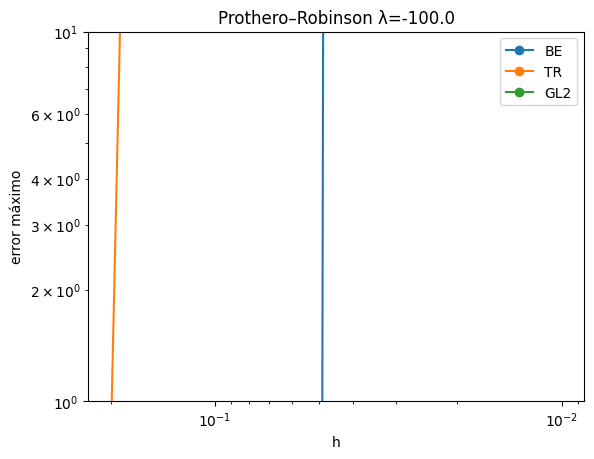

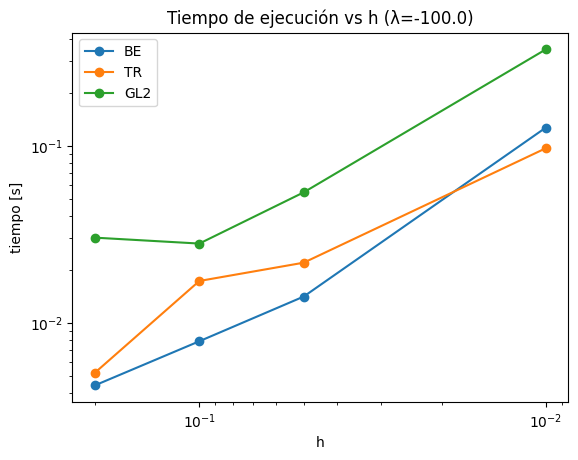

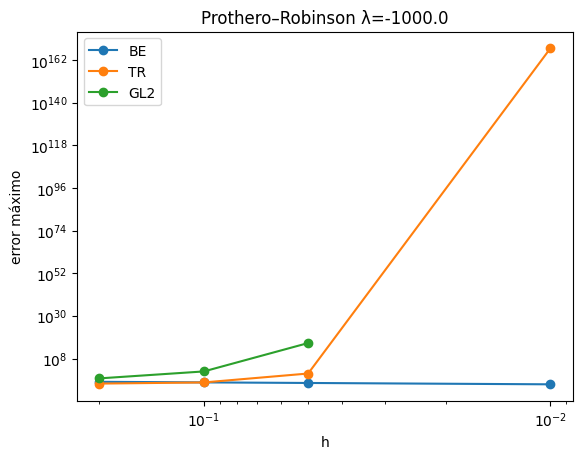

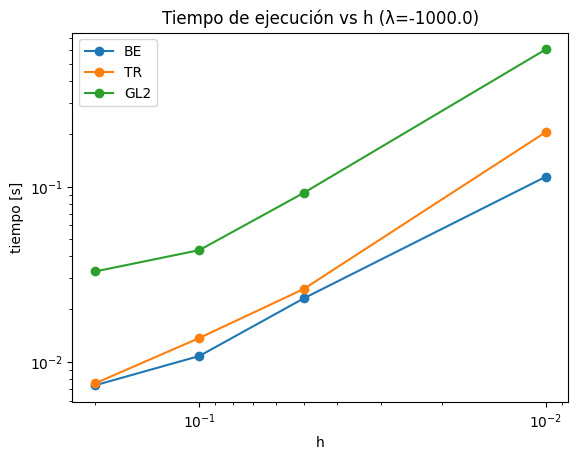

In [ ]:

lambdas = [-100.0, -1000.0]
hs = [0.2, 0.1, 0.05, 0.01]
methods = ["BE","TR","GL2"]

for L in lambdas:
    errs = {m: [] for m in methods}
    times = {m: [] for m in methods}
    for h in hs:
        for m in methods:
            t, y, yex, e, dt = run_prothero(L, method=m, h=h)
            errs[m].append(e); times[m].append(dt)
    plt.figure()
    for m in methods:
        plt.loglog(hs, errs[m], 'o-', label=m)
    plt.gca().invert_xaxis()
    plt.xlabel('h'); plt.ylabel('error máximo'); plt.title(f'Prothero–Robinson λ={L}')
    plt.legend(); plt.show()
    plt.figure()
    for m in methods:
        plt.loglog(hs, times[m], 'o-', label=m)
    plt.gca().invert_xaxis()
    plt.xlabel('h'); plt.ylabel('tiempo [s]'); plt.title(f'Tiempo de ejecución vs h (λ={L})')
    plt.legend(); plt.show()



## 5) Ejercicio 2 — Van der Pol (μ=15): capas límite
**Qué hacer:**
1. Ejecuta **BE, TR, GL2** con $h=0.1$ en $t\in[0,40]$.
2. Grafica $y_1(t)$ e identifica transiciones rápidas.


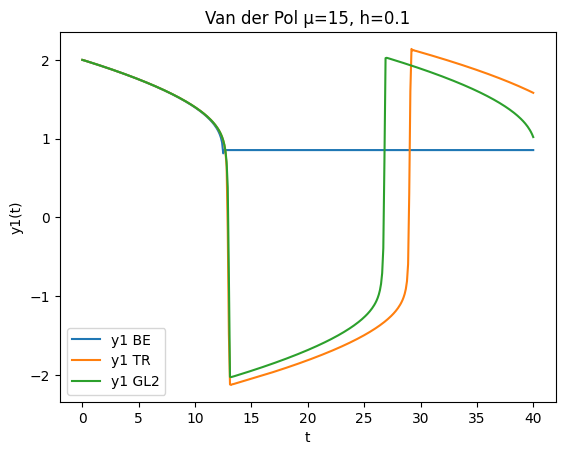

Tiempos [s]: BE=0.050, TR=0.037, GL2=0.111


In [ ]:

t, Y_be,  t_be  = run_vdp(mu=15.0, method="BE",  h=0.1)
t, Y_tr,  t_tr  = run_vdp(mu=15.0, method="TR",  h=0.1)
t, Y_gl2, t_gl2 = run_vdp(mu=15.0, method="GL2", h=0.1)

plt.figure()
plt.plot(t, Y_be[:,0],  label="y1 BE")
plt.plot(t, Y_tr[:,0],  label="y1 TR")
plt.plot(t, Y_gl2[:,0], label="y1 GL2")
plt.xlabel("t"); plt.ylabel("y1(t)"); plt.title("Van der Pol μ=15, h=0.1")
plt.legend(); plt.show()
print(f"Tiempos [s]: BE={t_be:.3f}, TR={t_tr:.3f}, GL2={t_gl2:.3f}")



## 6) Ejercicio 3 — FitzHugh–Nagumo: rigidez por separación de escalas
Parámetros base: $a=0.7,\ b=0.8,\ c=3,\ \tau\in\{0.02, 0.08, 0.2\}$.

1. Ejecuta **TR y GL2** con $h=0.01$.
2. Grafica $u(t)$ y comenta la rigidez al variar $\tau$.


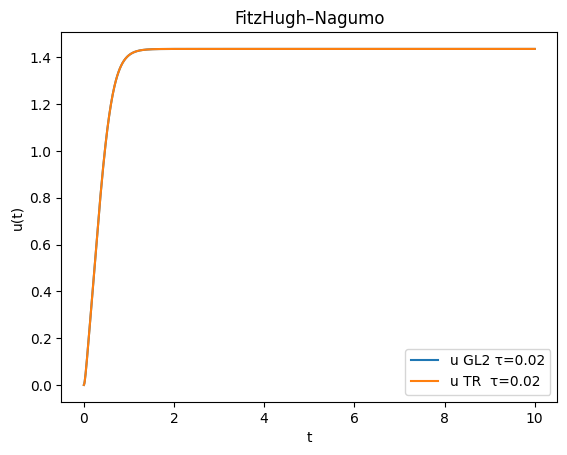

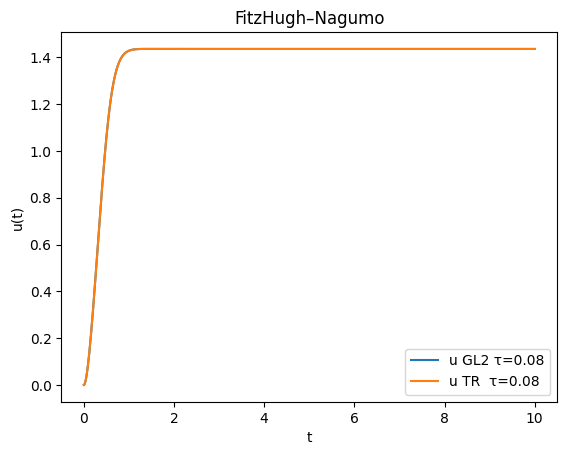

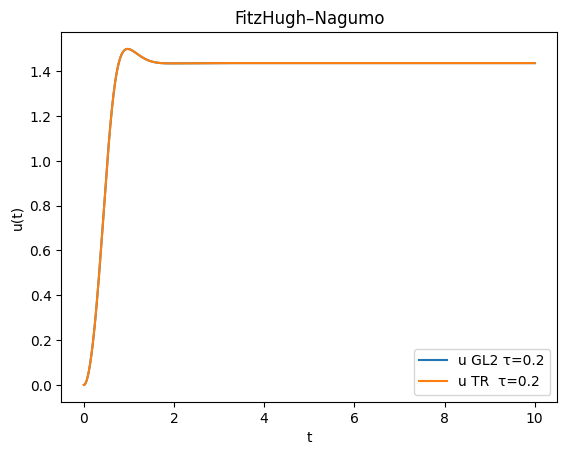

In [ ]:

for tau in (0.02, 0.08, 0.2):
    t, Y_gl2, tg = run_fhn(tau=tau, method="GL2", h=0.01)
    t, Y_tr,  tt = run_fhn(tau=tau, method="TR",  h=0.01)
    plt.figure()
    plt.plot(t, Y_gl2[:,0], label=f"u GL2 τ={tau}")
    plt.plot(t, Y_tr[:,0],  label=f"u TR  τ={tau}")
    plt.xlabel("t"); plt.ylabel("u(t)"); plt.title("FitzHugh–Nagumo")
    plt.legend(); plt.show()



---
## 8) Entregables
- Figuras y **comentarios** (½–1 página por ejercicio) sobre **estabilidad**, **error** y **costo**.
- No entregues implementación; solo resultados y análisis.
